In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.base import TransformerMixin
from dateutil.parser import parse
from sklearn.model_selection import GridSearchCV

In [5]:
class Transform(TransformerMixin):
    def fit(self, X, y=None):
        self.encoders = dict()
        for column in X.columns:
            if X.dtypes[column] == object:
                X[column] = X[column].fillna(X[column].value_counts().index[0])
                self.encoders[column] = preprocessing.LabelEncoder()
                self.encoders[column] = self.encoders[column].fit(X[column])
            
    def transform(self, X, y=None):
        X = X.drop(['ID'], axis=1)
        X = X.fillna(X.mean(axis = 0))
        
        X['Latitude_cos'] = X.Latitude.apply(lambda x : np.cos(x))
        X['Latitude'] = X.Latitude.apply(lambda x : np.sin(x))
        
        X['Longitude_cos'] = X.Longitude.apply(lambda x : np.cos(x))
        X['Longitude'] = X.Longitude.apply(lambda x : np.sin(x))
        
        X = X.rename(columns = {'Latitude': 'Latitude_sin', 'Longitude':'Longitude_sin'})
        
        X['Date'] = X.Date.apply(lambda x : parse(x).timestamp())
        X['Time'] = X.Time.apply(lambda x : parse(x).timestamp())

        for column in self.encoders:
            if column not in ['Date','Time','ID']:
                X[column] = self.encoders[column].transform(X[column])
        return X

In [7]:
data = pd.read_csv('database.csv')

In [8]:
transf = Transform()
transf.fit(data)
data = transf.transform(data)


In [10]:
train, test = train_test_split(data, test_size=0.33)


In [11]:
target = ['Magnitude']
predictors = [col for col in train.columns if col not in target]


In [12]:
#selecting_features_related_to_target

dec_tree = tree.DecisionTreeRegressor()
parameters = {'max_depth': range(2,10), 'min_samples_split' : range(2,10),
              'min_samples_leaf' : range(2,10)}

clf = GridSearchCV(dec_tree, parameters)
clf = clf.fit(train[predictors], train[target])
maxdepth =  clf.best_params_['max_depth']
minsamplessplit = clf.best_params_['min_samples_split']
minsampleasleaf = clf.best_params_['min_samples_leaf']
print(maxdepth)


dec_tree = tree.DecisionTreeRegressor(max_depth = maxdepth, min_samples_split=minsamplessplit,
                                     min_samples_leaf = minsampleasleaf)
clf1 = dec_tree.fit(train[predictors], train[target])
model = SelectFromModel(clf1, prefit=True)
mask = model.get_support()
predictors = [predictors[i] for i in range(len(mask)) if mask[i] == True]


8


In [15]:
clf = dec_tree.fit(train[predictors], train[target])
clf.score(train[predictors], train[target])

0.23545321422752621

In [16]:
train_prediction = clf.predict(train[predictors])
test_prediction= clf.predict(test[predictors])

In [17]:
train_loss = np.mean((train_prediction.reshape(-1,1) - np.array(train[target]))**2)
test_loss = np.mean((test_prediction.reshape(-1,1) - np.array(test[target]))**2)
print('Train loss = ', train_loss)
print('Test loss =', test_loss)

Train loss =  0.13502522732577565
Test loss = 0.15050884620941637


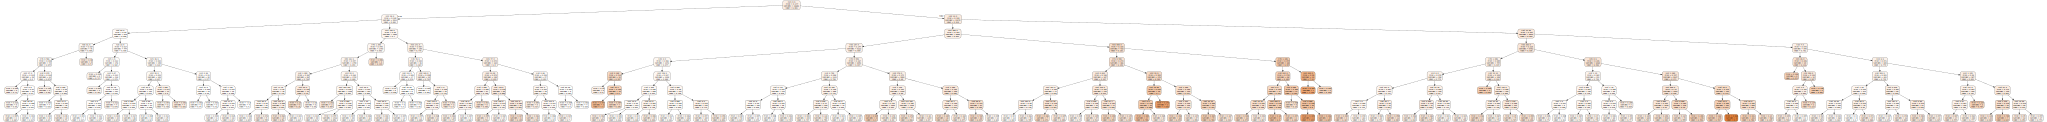

In [18]:
import graphviz
dot_data = tree.export_graphviz(clf1, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("simple_tree")

dot_data = tree.export_graphviz(clf1, out_file=None,  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = graphviz.Source(dot_data)  
graph 